In [25]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch import nn
# from torch.utils.data import DataLoader
# from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from sklearn.model_selection import train_test_split


In [24]:
import os 
g = os.listdir('C:/Users/laure/Documents/proj_loopr/processed_images')
int(g[9][5:8])

0

In [2]:
def create_gaborfilter():
    # This function is designed to produce a set of GaborFilters 
    # an even distribution of theta values equally distributed amongst pi rad / 180 degree
     
    filters = []
    num_filters = 32
    ksize = 16  # The local area to evaluate
    sigma = 2. #3.0  # Larger Values produce more edges
    lambd = 20. #10.0
    gamma = 2. #0.5
    psi = 0.  # Offset value - lower generates cleaner results
    for theta in np.linspace(0, np.pi, num_filters, endpoint=False):  # Theta is the orientation for edge detection
        kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_64F)
        kern /= 1.0 * kern.sum()  # Brightness normalization
        filters.append(kern)
    return filters

def apply_filter(img, filters):
# This general function is designed to apply filters to our image
     
    # First create a numpy array the same size as our input image
    newimage = np.zeros_like(img)
     
    # Starting with a blank image, we loop through the images and apply our Gabor Filter
    # On each iteration, we take the highest value (super impose), until we have the max value across all filters
    # The final image is returned
    depth = -1 # remain depth same as original image
     
    for kern in filters:  # Loop through the kernels in our GaborFilter
        image_filter = cv2.filter2D(img, depth, kern)  #Apply filter to image
         
        # Using Numpy.maximum to compare our filter and cumulative image, taking the higher value (max)
        np.maximum(newimage, image_filter, newimage)
    return newimage

def sliding_window(image, sq_size = 32, pix_steps=4):
    img_list = []
    for i in np.arange(0,image.shape[0]-sq_size+pix_steps,pix_steps):
        for j in np.arange(0,image.shape[1]-sq_size+pix_steps,pix_steps):
            img_list.append(image[i:i+sq_size,j:j+sq_size])
    return np.array(img_list)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, 2)
        self.pool = nn.MaxPool2d(2,stride=1)
        self.conv2 = nn.Conv2d(4, 10, 4,2)
        self.fc1 = nn.Linear( 1960, 120)   
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x,1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x


net = Net()

In [4]:

# criterion = nn.CrossEntropyLoss()
# class DiceLoss(nn.Module):
#     def __init__(self):
#         super(DiceLoss, self).__init__()

#     def forward(self, dats,labs):
#         eps = 10**(-5)
#         fin = torch.sum(dats[:,1]*labs[:,1])
#         div = torch.sum(dats[:,1]) +torch.sum(labs[:,1])
#         return 1 - ((2*fin+eps)/(div+eps))

# class DiceLoss(nn.Module):
#     def __init__(self, weight=None, size_average=True):
#         super(DiceLoss, self).__init__()

#     def forward(self, inputs, targets, smooth=1):

#         inputs = F.sigmoid(inputs)

#         inputs = inputs.view(-1)
#         targets = targets.view(-1)

#         intersection = (inputs * targets).sum()
#         dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

#         return 1 - dice

criterion  = nn.CrossEntropyLoss() #DiceLoss()
optimizer = optim.Adam(net.parameters(), lr=5e-5)

In [5]:
img = cv2.imread('C:/Users/laure/Documents/proj_loopr/archive/Defect_images/0027_019_02.png',cv2.IMREAD_GRAYSCALE)
# img = cv2.GaussianBlur(img,(11,11),0)
gfilters = create_gaborfilter()
image_g = apply_filter(img, gfilters)

img_list = sliding_window(image_g.astype(np.single))
print(img_list.shape)

img = cv2.imread('C:/Users/laure/Documents/proj_loopr/archive/Defect_images/0045_019_04.png',cv2.IMREAD_GRAYSCALE)
# img = cv2.GaussianBlur(img,(11,11),0)
# gfilters = create_gaborfilter()
image_g = apply_filter(img, gfilters)

img_list = np.vstack((img_list,sliding_window(image_g.astype(np.single))))
print(img_list.shape)

# norm_img_list = img_list -np.sum(img_list,axis=0)
# norm_img_list = norm_img_list/np.sqrt(np.mean(norm_img_list**2))
# # norm_img_list = norm_img_list.reshape(960,256**2)
# print(norm_img_list.shape)


(57969, 32, 32)
(115938, 32, 32)


In [6]:
mask_im = cv2.imread('C:/Users/laure/Documents/proj_loopr/archive/Mask_images/0027_019_02_mask.png',cv2.IMREAD_GRAYSCALE)
mask_list = sliding_window(mask_im)
mask_im = cv2.imread('C:/Users/laure/Documents/proj_loopr/archive/Mask_images/0045_019_04_mask.png',cv2.IMREAD_GRAYSCALE)
mask_list = np.vstack((mask_list, sliding_window(mask_im)))
labels = np.zeros(img_list.shape[0])
for el in range(mask_list.shape[0]):
    if np.amax(mask_list[el])>0:
        labels[el]=1
    # else:
    #     labels[el,0]=1.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(img_list, labels, test_size=0.1, random_state=81)


In [8]:
np.sum(y_test)

15.0

In [9]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=81)
X_train, y_train = smote.fit_resample(X_train.reshape(-1, 32**2), y_train)

X_train = X_train.reshape(-1, 32, 32)
labels = np.zeros((X_train.shape[0], 2))
labels[:,1] = y_train
labels[np.argwhere(y_train==0).flatten(),0] = 1

test_labels = np.zeros((X_test.shape[0], 2))
test_labels[:,1] = y_test
test_labels[np.argwhere(y_test==0).flatten(),0] = 1

In [10]:
np.argwhere(labels[:,1]>0).shape

(104180, 1)

In [11]:
X_train.shape

(208360, 32, 32)

In [12]:
labels.shape

(208360, 2)

In [13]:
train_dataset = TensorDataset(torch.from_numpy(X_train.reshape(-1,1,32,32)), torch.tensor(labels))
train_loader = DataLoader(train_dataset,batch_size=50,sampler = RandomSampler(train_dataset, replacement=False, num_samples=50000)) 
val_dataset = TensorDataset(torch.from_numpy(X_test.reshape(-1,1,32,32)), torch.tensor(test_labels))
val_loader = DataLoader(val_dataset, batch_size=50) 

In [14]:
img_list.reshape(-1,1,32,32).shape

(115938, 1, 32, 32)

In [15]:
np.sum(labels[:,1])

104180.0

In [16]:
# batch_size=5
total_epochs = 50
losses = np.zeros(total_epochs)
for epoch in range(total_epochs):  # loop over the dataset multiple times

    running_loss = 0.0

    # rand_list = np.arange(mask_list.shape[0])
    # np.random.shuffle(rand_list)

    # new_img_list = img_list[rand_list,:,:]
    # new_labels = labels[rand_list,:]
    
    for batch, (inputs, lab) in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data
        # inputs = torch.from_numpy(new_img_list[i*batch_size:(i+1)*batch_size,:,:].reshape(batch_size,1,32,32))
        # lab = torch.tensor(new_labels[i*batch_size:(i+1)*batch_size,:])

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, lab)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # if i % 2000 == 1999:    # print every 2000 mini-batches
        #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
        #     running_loss = 0.0 
    
    with torch.no_grad():
        val_loss = 0.
        for batch, (val_inputs, val_labels) in enumerate(val_loader):#val_sample in test_loader:
        #         #val_features, val_labels = next(iter(test_loader))
            val_outputs = net(val_inputs)
            valloss = criterion(val_outputs, val_labels)
            val_loss +=valloss.item()

    print("Epoch "+str(epoch+1)+": \n Training Loss is: "+str(running_loss))
    print(" Validation Loss is: "+str(val_loss))
    losses[epoch] = running_loss
print('Finished Training')

Epoch 1: 
 Training Loss is: 689.9980454134942
 Validation Loss is: 145.1823539300939
Epoch 2: 
 Training Loss is: 628.2845839190489
 Validation Loss is: 103.71205641096286
Epoch 3: 
 Training Loss is: 458.28163229405857
 Validation Loss is: 85.91090893932363
Epoch 4: 
 Training Loss is: 398.0878499633072
 Validation Loss is: 100.10553968784482
Epoch 5: 
 Training Loss is: 378.466938974857
 Validation Loss is: 91.14695420156825
Epoch 6: 
 Training Loss is: 364.26843053758205
 Validation Loss is: 85.95404841282154
Epoch 7: 
 Training Loss is: 356.85688416779055
 Validation Loss is: 81.50447306776593
Epoch 8: 
 Training Loss is: 347.7010504883527
 Validation Loss is: 84.51289564511994
Epoch 9: 
 Training Loss is: 339.5092954045534
 Validation Loss is: 79.43965007722379
Epoch 10: 
 Training Loss is: 334.28878259897255
 Validation Loss is: 80.96224745295261
Epoch 11: 
 Training Loss is: 330.19404477953935
 Validation Loss is: 76.09004522288386
Epoch 12: 
 Training Loss is: 326.799733139276

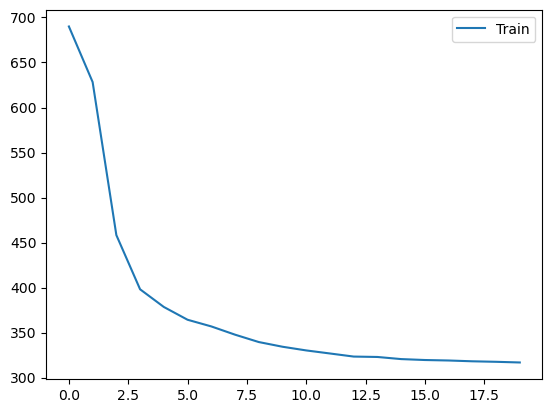

In [17]:
plt.figure()
plt.plot(np.arange(total_epochs),losses,label="Train")
# plt.plot(np.arange(total_epochs),val_losses, label="Val")
plt.legend()
plt.show()

In [28]:
criterion(outputs, lab)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], dtype=torch.float64)

In [50]:
eps = 10**(-10)
fin = torch.sum(outputs[:,1]*lab[:,1])
div = torch.sum(outputs[:,1]) +torch.sum(lab[:,1])

In [52]:
div

tensor(2.5053, dtype=torch.float64, grad_fn=<AddBackward0>)

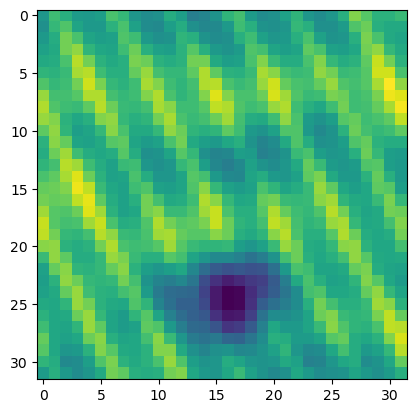

In [52]:

plt.imshow(X_train[22840,:,:])
plt.show()

In [53]:
net.forward(torch.from_numpy(X_train[22830:22850,:,:].reshape(20,1,32,32)))

tensor([[1.0000e+00, 9.4098e-12],
        [1.0000e+00, 5.8172e-12],
        [1.0000e+00, 7.2447e-19],
        [1.0000e+00, 4.5831e-19],
        [1.0000e+00, 2.4411e-22],
        [1.0000e+00, 2.6417e-18],
        [3.0331e-07, 1.0000e+00],
        [1.3129e-06, 1.0000e+00],
        [1.1531e-09, 1.0000e+00],
        [5.1686e-08, 1.0000e+00],
        [2.5635e-11, 1.0000e+00],
        [1.5481e-09, 1.0000e+00],
        [1.7474e-06, 1.0000e+00],
        [5.7472e-05, 9.9994e-01],
        [6.8163e-04, 9.9932e-01],
        [1.0000e+00, 3.9844e-27],
        [1.0000e+00, 8.2854e-34],
        [1.0000e+00, 1.2769e-28],
        [1.0000e+00, 4.5010e-18],
        [1.0000e+00, 4.1287e-18]], grad_fn=<SoftmaxBackward0>)

In [54]:
labels[22830:22850,:]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [24]:
net.forward(torch.from_numpy(img_list[67,:,:].reshape(1,1,32,32)))

tensor([[1., 0.]], grad_fn=<SoftmaxBackward0>)